<a href="https://colab.research.google.com/github/danhorsley/DS-Unit-4-Sprint-1-NLP/blob/master/LS_DS_415_Sprint_Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

# Sprint Challenge
## *Data Science Unit 4 Sprint 1*

After a week of Natural Language Processing, you've learned some cool new stuff: how to process text, how turn text into vectors, and how to model topics from documents. Apply your newly acquired skills to one of the most famous NLP datasets out there: [Yelp](https://www.yelp.com/dataset/challenge). As part of the job selection process, some of my friends have been asked to create analysis of this dataset, so I want to empower you to have a head start.  

The real dataset is massive (almost 8 gigs uncompressed). I've sampled the data for you to something more managable for the Sprint Challenge. You can analyze the full dataset as a stretch goal or after the sprint challenge. As you work on the challenge, I suggest adding notes about your findings and things you want to analyze in the future.

## Challenge Objectives
*Successfully complete these all these objectives to earn a 2. There are more details on each objective further down in the notebook.*
* <a href="#p1">Part 1</a>: Write a function to tokenize the yelp reviews
* <a href="#p2">Part 2</a>: Create a vector representation of those tokens
* <a href="#p3">Part 3</a>: Use your tokens in a classification model on yelp rating
* <a href="#p4">Part 4</a>: Estimate & Interpret a topic model of the Yelp reviews

In [1]:
from google.colab import files
upl = files.upload()

Saving review_sample.json to review_sample.json


In [0]:
import pandas as pd

#yelp = pd.read_json('./data/review_sample.json', lines=True)
yelp = pd.read_json('review_sample.json', lines=True)

In [3]:
yelp.head()

,business_id,cool,date,funny,review_id,stars,text,useful,user_id
0,nDuEqIyRc8YKS1q1fX0CZg,1,2015-03-31 16:50:30,0,eZs2tpEJtXPwawvHnHZIgQ,1,"BEWARE!!! FAKE, FAKE, FAKE....We also own a sm...",10,n1LM36qNg4rqGXIcvVXv8w
1,eMYeEapscbKNqUDCx705hg,0,2015-12-16 05:31:03,0,DoQDWJsNbU0KL1O29l_Xug,4,Came here for lunch Togo. Service was quick. S...,0,5CgjjDAic2-FAvCtiHpytA
2,6Q7-wkCPc1KF75jZLOTcMw,1,2010-06-20 19:14:48,1,DDOdGU7zh56yQHmUnL1idQ,3,I've been to Vegas dozens of times and had nev...,2,BdV-cf3LScmb8kZ7iiBcMA
3,k3zrItO4l9hwfLRwHBDc9w,3,2010-07-13 00:33:45,4,LfTMUWnfGFMOfOIyJcwLVA,1,We went here on a night where they closed off ...,5,cZZnBqh4gAEy4CdNvJailQ
4,6hpfRwGlOzbNv7k5eP9rsQ,1,2018-06-30 02:30:01,0,zJSUdI7bJ8PNJAg4lnl_Gg,4,"3.5 to 4 stars\n\nNot bad for the price, $12.9...",5,n9QO4ClYAS7h9fpQwa5bhA


## Part 1: Tokenize Function
<a id="#p1"></a>

Complete the function `tokenize`. Your function should
- accept one document at a time
- return a list of tokens

You are free to use any method you have learned this week.

In [0]:
import spacy
from spacy.tokenizer import Tokenizer
nlp = spacy.load("en_core_web_sm")
tokenizer = Tokenizer(nlp.vocab)

In [0]:
my_words = ['ve','it','go','don']

In [0]:
#testing stuff
#for x in tokenizer.tokens_from_list(yelp['text'][0].split()):
#  print(x.lemma_)

In [0]:
def tokenize(doc):
    tokens=[]
    for text in tokenizer.tokens_from_list(doc.split()):

      if (text.is_stop == False) and (text.is_punct==False) and (text.is_space==False) and (text.lemma_ not in my_words):
        tokens.append(text.lemma_)     
    
    return tokens

In [34]:
#testing fucntion
tokenize(yelp['text'][0])[:5]

['BEWARE!!!', 'FAKE,', 'FAKE,', 'FAKE....We', 'small']

## Part 2: Vector Representation
<a id="#p2"></a>
1. Create a vector representation of the reviews
2. Write a fake review and query for the 10 most similiar reviews, print the text of the reviews. Do you notice any patterns?
    - Given the size of the dataset, it will probably be best to use a `NearestNeighbors` model for this. 

In [0]:
#first we make a new column of the tokens
yelp['tokens'] = yelp['text'].apply(tokenize)

In [50]:
#checking new column
yelp.head(2)

,business_id,cool,date,funny,review_id,stars,text,useful,user_id,tokens
0,nDuEqIyRc8YKS1q1fX0CZg,1,2015-03-31 16:50:30,0,eZs2tpEJtXPwawvHnHZIgQ,1,"BEWARE!!! FAKE, FAKE, FAKE....We also own a sm...",10,n1LM36qNg4rqGXIcvVXv8w,"[BEWARE!!!, FAKE,, FAKE,, FAKE....We, small, b..."
1,eMYeEapscbKNqUDCx705hg,0,2015-12-16 05:31:03,0,DoQDWJsNbU0KL1O29l_Xug,4,Came here for lunch Togo. Service was quick. S...,0,5CgjjDAic2-FAvCtiHpytA,"[Came, lunch, Togo., Service, quick., Staff, f..."


In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer

def add_vectors(frame,num_features=20):
    tfidf = TfidfVectorizer(max_features = num_features)
    mystrings = [' '.join(x) for x in list(frame['tokens'])]
    tfidf.fit(mystrings)
    dtm = tfidf.transform(mystrings)
    vectorframe = pd.DataFrame(dtm.todense(), columns = tfidf.get_feature_names())
    #return pd.merge(frame,vectorframe,left_index=True,right_index=True)
    #return vectorframe
    return dtm

In [0]:
yelp_v = add_vectors(yelp)

In [63]:
yelp_v.head()

,come,don,food,get,good,great,it,like,look,love,nice,order,place,restaurant,service,time,try,ve,want,well
0,0.0,0.0,0.00000,0.00000,0.000000,0.0,0.0,0.455882,0.568395,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.442615,0.522676,0.000000,0.0,0.000000
1,0.0,0.0,0.00000,0.00000,0.697192,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.716885,0.000000,0.000000,0.000000,0.0,0.000000
2,0.0,0.0,0.00000,0.30073,0.000000,0.0,0.0,0.269679,0.336236,0.0,0.677962,0.0,0.000000,0.0,0.000000,0.261831,0.000000,0.338506,0.0,0.284614
3,0.0,0.0,0.00000,0.00000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.636693,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.771117
4,0.0,0.0,0.50124,0.00000,0.511698,0.0,0.0,0.000000,0.697799,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000


In [85]:
from sklearn.neighbors import NearestNeighbors
nn = NearestNeighbors(n_neighbors=10, algorithm ='ball_tree')
mystrings = [' '.join(x) for x in list(yelp['tokens'])]
tfidf = TfidfVectorizer(max_features = 20)
tfidf.fit(mystrings)
nn.fit(yelp_v)
my_fake_review = ["""this is my nice FAKE review.  let's try what other great reviews 
are closest to this terrible review I have written.  the restaurant was great, the service was good
and the food was not bad.  come here!"""]
new = tfidf.transform(my_fake_review)
new.todense()
revs = nn.kneighbors(new.todense())[1]
for rev in revs[0]:
  print(mystrings[rev])

food service Great... highly recommend restaurant.... manager experience great... Try jalepena cheese dip
crave Indian food coupon BF decide try place dinner. share tandoori chicken, Rogan Josh (heat level 5 10), plain basmati rice, garlic naan. Food fresh, aromatic sizzle arrive table. Service great waiter super polite quick fill water. Sunday 7, group restaurant. great experience definitely come dinner check lunch buffet.
Prosecco Friday night dinner. Having hear great restaurant eager try it. Friends tell food great, service great great host owner was. excited. True food good, service good. waiter Joaquin terrific. However, owner, Guiseppe, great disappointment. sit watch single table, twice, speak guest sit table talk ask was. sit good 90 minute come table food service was. visit table twice. bill $100 wasn't take space ordering. insulted. husband stop talk leave tell food great notice stop table others, lie say "was putt fires." watch hour visit table. pay left. again. chance impr

/usr/local/lib/python3.6/dist-packages/sklearn/neighbors/base.py:216: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "


## Part 3: Classification
<a id="#p3"></a>
Your goal in this section will be to predict `stars` from the review dataset. 

1. Create a piepline object with a sklearn `CountVectorizer` or `TfidfVector` and any sklearn classifier. Use that pipeline to estimate a model to predict `stars`. Use the Pipeline to predict a star rating for your fake review from Part 2. 
2. Tune the entire pipeline with a GridSearch

In [88]:
yv = pd.merge(yelp,pd.DataFrame(yelp_v.todense(), columns = tfidf.get_feature_names()),left_index=True,right_index=True)
yv.head(2)

,business_id,cool,date,funny,review_id,stars,text,useful,user_id,tokens,come,don,food,get,good,great,it,like,look,love,nice,order,place,restaurant,service,time,try,ve,want,well
0,nDuEqIyRc8YKS1q1fX0CZg,1,2015-03-31 16:50:30,0,eZs2tpEJtXPwawvHnHZIgQ,1,"BEWARE!!! FAKE, FAKE, FAKE....We also own a sm...",10,n1LM36qNg4rqGXIcvVXv8w,"[BEWARE!!!, FAKE,, FAKE,, FAKE....We, small, b...",0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.455882,0.568395,0.0,0.0,0.0,0.0,0.0,0.000000,0.442615,0.522676,0.0,0.0,0.0
1,eMYeEapscbKNqUDCx705hg,0,2015-12-16 05:31:03,0,DoQDWJsNbU0KL1O29l_Xug,4,Came here for lunch Togo. Service was quick. S...,0,5CgjjDAic2-FAvCtiHpytA,"[Came, lunch, Togo., Service, quick., Staff, f...",0.0,0.0,0.0,0.0,0.697192,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.716885,0.000000,0.000000,0.0,0.0,0.0


In [93]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
vect = TfidfVectorizer(stop_words='english')
sgdc = SGDClassifier()

mystrings = [' '.join(x) for x in list(yelp['tokens'])]

pipe = Pipeline([('vect', vect), ('clf', sgdc)])
pipe.fit(mystrings, yelp['stars'])

Pipeline(memory=None,
         steps=[('vect',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words='english', strip_accents=None,
                                 sublinear_tf=False,
                                 token_patte...
                 SGDClassifier(alpha=0.0001, average=False, class_weight=None,
                               early_stopping=False, epsilon=0.1, eta0=0.0,
                               fit_intercept=True, l1_ratio=0.15,
                               learning_rate='optimal', loss='hinge',
           

In [94]:
#looks like my fake review is a five star restuarant!!!
pipe.predict(my_fake_review)

array([5])

## Part 4: Topic Modeling

Let's find out what those yelp reviews are saying! :D

1. Estimate a LDA topic model of the review text
2. Create 1-2 visualizations of the results
    - You can use the most important 3 words of a topic in relevant visualizations. Refer to yesterday's notebook to extract. 
3. In markdown, write 1-2 paragraphs of analysis on the results of your topic model

__*Note*__: You can pass the DataFrame column of text reviews to gensim. You do not have to use a generator.

In [0]:
import numpy as np
import re
import gensim
from gensim.utils import smart_open, simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora
from gensim.models.ldamulticore import LdaMulticore


In [0]:
id2word = corpora.Dictionary(yelp['tokens'])

In [0]:
corpus = [id2word.doc2bow(text) for text in yelp['tokens']]

In [0]:
lda = LdaMulticore(corpus=corpus,
                   id2word=id2word,
                   random_state=723812,
                   num_topics = 15,
                   passes=10,
                   workers=4
                  )

In [0]:
words = [re.findall(r'"([^"]*)"',t[1]) for t in lda.print_topics()]

In [109]:
topics = [' '.join(t[0:5]) for t in words]
topics

['place like get well good',
 'time come place like order',
 'place food like great come',
 'food great like place service',
 'place time like good tell',
 'food order come time good',
 "like time good I've come",
 'great food come place service',
 'time service place food try',
 'order like table try food',
 'like place come food time',
 'place food good get come',
 'call work take tell time',
 'room like place get come',
 'place come like good get']

In [0]:
!pip install pyLDAvis

In [0]:
import warnings
warnings.filterwarnings("ignore")

In [150]:
#this took too long to run - looks like right code to me but had it on for 15 minutes and no joy
#so i ran it on a  much smaller subset
import pyLDAvis.gensim
n=500
id2word_mini = corpora.Dictionary(yelp['tokens'][:n])
corpus_mini = [id2word_mini.doc2bow(text) for text in yelp['tokens'][:n]]
lda_mini = LdaMulticore(corpus=corpus_mini,
                   id2word=id2word_mini,
                   random_state=55,
                   num_topics = 10,
                   passes=10,
                   workers=4
                  )
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(lda_mini, corpus_mini, id2word_mini)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.077596  0.041068       1        1  17.317703
8     -0.079817  0.017642       2        1  17.072355
2     -0.035430 -0.127111       3        1  13.114478
6     -0.053037  0.023646       4        1  11.552596
5     -0.034962 -0.042436       5        1  11.421035
9     -0.007006  0.067553       6        1   7.714972
1      0.138549 -0.020411       7        1   6.090494
0      0.064452  0.013689       8        1   5.830209
3      0.056388  0.054796       9        1   5.179441
7      0.028458 -0.028436      10        1   4.706712, topic_info=     Category        Freq      Term       Total  loglift  logprob
24    Default  124.000000      like  124.000000  30.0000  30.0000
981   Default   23.000000   Chinese   23.000000  29.0000  29.0000
437   Default  119.000000     order  119.000000  28.0000  28.0000
119   Default   43.000000      room   43.000000  27.0000  27.0000
1146  Default   31.000000    you're   31.000000  26.0000  26.0000
1572  Default   34.000000   chicken   34.000000  25.0000  25.0000
150   Default   81.000000      well   81.000000  24.0000  24.0000
42    Default   67.000000      wait   67.000000  23.0000  23.0000
782   Default   59.000000    didn't   59.000000  22.0000  22.0000
1189  Default   23.000000  sandwich   23.000000  21.0000  21.0000
374   Default   24.000000  waitress   24.000000  20.0000  20.0000
957   Default   64.000000      it's   64.000000  19.0000  19.0000
879   Default   75.000000      love   75.000000  18.0000  18.0000
17    Default   27.000000      call   27.000000  17.0000  17.0000
545   Default   36.000000      hour   36.000000  16.0000  16.0000
205   Default   26.000000     food.   26.000000  15.0000  15.0000
400   Default  138.000000      come  138.000000  14.0000  14.0000
598   Default   43.000000      tell   43.000000  13.0000  13.0000
518   Default   35.000000  customer   35.000000  12.0000  12.0000
170   Default   29.000000       fry   29.000000  11.0000  11.0000
41    Default  101.000000       try  101.000000  10.0000  10.0000
1248  Default   52.000000      It's   52.000000   9.0000   9.0000
499   Default   57.000000       ask   57.000000   8.0000   8.0000
455   Default   49.000000     staff   49.000000   7.0000   7.0000
111   Default   22.000000       old   22.000000   6.0000   6.0000
375   Default   57.000000      work   57.000000   5.0000   5.0000
2249  Default   11.000000    French   11.000000   4.0000   4.0000
31    Default   27.000000    minute   27.000000   3.0000   3.0000
1003  Default   24.000000       car   24.000000   2.0000   2.0000
102   Default   38.000000      long   38.000000   1.0000   1.0000
...       ...         ...       ...         ...      ...      ...
4098  Topic10    1.828668     here,    7.013430   1.7119  -6.5780
389   Topic10    3.009749       big   19.486534   1.1883  -6.0797
157   Topic10    3.507756       bad   28.571640   0.9587  -5.9266
111   Topic10    3.012735       old   22.026951   1.0668  -6.0787
92    Topic10    5.846743       get  117.038582   0.0596  -5.4157
116   Topic10    2.413396    reason   13.657726   1.3229  -6.3005
690   Topic10    2.417431      line   14.152141   1.2890  -6.2989
205   Topic10    3.015110     food.   26.182337   0.8947  -6.0779
1093  Topic10    2.951630      item   25.040348   0.9180  -6.0992
957   Topic10    4.189929      it's   64.257294   0.3260  -5.7489
145   Topic10    5.953869     place  176.470200  -0.3329  -5.3975
160   Topic10    3.510341      bite   43.844086   0.5313  -5.9258
143   Topic10    3.400237    people   41.682674   0.5499  -5.9577
241   Topic10    4.669335     great  122.101616  -0.2077  -5.6405
42    Topic10    3.803755      wait   67.717796   0.1768  -5.8456
420   Topic10    3.595187      find   57.228432   0.2887  -5.9020
41    Topic10    4.233367       try  101.053413  -0.1165  -5.7386
1773  Topic10    3.007262       way   33.389503   0.6490  -6.0805
2166  Top

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['b', 'c', 'd', 'e', 'f', 'g', 'h', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


<BarContainer object of 20 artists>

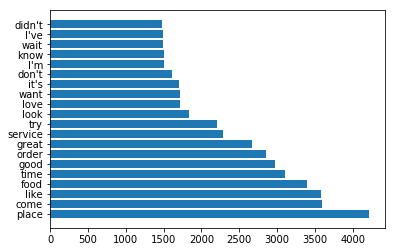

In [114]:
#plotting 20 most common tokens
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(tokenizer=lambda doc: doc, lowercase=False, stop_words='english')
dtm = vectorizer.fit_transform(yelp['tokens'])
dtm = pd.DataFrame(dtm.todense(), columns = vectorizer.get_feature_names())
import matplotlib.pyplot as plt
common20 = dtm.sum().sort_values(ascending=False)[:20]
plt.barh(common20.index,list(common20))

<BarContainer object of 20 artists>

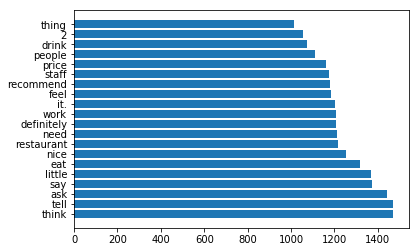

In [115]:
#now looking at 20-40 seeing if you can get more insight than the more basic words
#but it doesn't really help that much
common2040 = dtm.sum().sort_values(ascending=False)[20:40]
plt.barh(common2040.index,list(common2040))

It's clear here the topics are different combinations of adjectives and attributes a restaurant may have.  For example service, food, place, time, tables are the attributes and good, great, like.  If i had more time I would go back and take out some of the more common words from the topics (using the top and bottom filter described in the lectures).  

Also I think because I used a low number of vectors, there don't seem to be any negative words which would be good features for low star reviews.  Positive or mildly positive statements much be much more common than negative statements, also negative words may be more diverse (i.e. positive is good or great, but negative is terrible, bad, sucked etc etc)

one more thing.  I've had some really long run times on this sprint challenge.  not sure if it's because I'm using colab, but I doubt it would be signifigantly slower than my laptop


## Stretch Goals

Complete one of more of these to push your score towards a three: 
* Incorporate named entity recognition into your analysis
* Compare vectorization methods in the classification section
* Analyze more (or all) of the yelp dataset - this one is v. hard. 
* Use a generator object on the reviews file - this would help you with the analyzing the whole dataset.
* Incorporate any of the other yelp dataset entities in your analysis (business, users, etc.)

In [0]:
#trying some named entity recognition
#goign to make a new column called ord.  if review doesn't contain an org i will set it to 0
#otherwise i will put name of ORG
orgs=[]
for t in yelp['tokens']:
  doc = nlp(' '.join(t))
  classer=[]
  for ent in doc.ents:
    if ent.label_=="ORG":
      classer.append(ent.text)
    else:
      pass
   
  if classer == []:
    orgs.append(0)
  else:
    orgs.append(classer)
    
    

In [0]:
orgs_first = []
for x in orgs:
  if x==0:
    orgs_first.append(0)
  else:
    orgs_first.append(x[0])
yelp['orgs'] = orgs_first

In [138]:
#here we can see a helpful  classification into some restaurant styles and brands.  however, only 40% of reviews were populated
#and each subdivision is too small to be helpful
yelp['orgs'].value_counts()[0:10]

0            6724
BBQ            57
Starbucks      47
AYCE           32
AC             21
WOW            19
Mesa           16
Sushi          15
AZ             14
OMG            12
Name: orgs, dtype: int64

In [140]:

#seeing what other labels i could use
doc =nlp(' '.join(yelp['tokens'][555]))
for ent in doc.ents:
    print(ent.text, ent.start_char, ent.end_char, ent.label_)

Chingu Korean BBQ's 0 19 PERSON
Lunch Specials 20 34 ORG
5.99 36 40 MONEY
7 42 43 CARDINAL
2 dollar 64 72 MONEY
20 minute 156 165 TIME
Korean 244 250 NORP
Kimchi/Pork Bone/Tofu 387 408 ORG
5.99 415 419 MONEY


In [0]:
#let's try money and time
money=[]
for t in yelp['tokens']:
  doc = nlp(' '.join(t))
  classer=[]
  for ent in doc.ents:
    if ent.label_=="MONEY":
      classer.append(ent.text)
    else:
      pass
   
  if classer == []:
    money.append([0])
  else:
    money.append(classer)


In [143]:
#no use either
yelp['money'] = [x[0] for x in money]
yelp['money'].value_counts()[:10]

0      8629
10       67
5        55
20       39
50       37
1        34
12       32
25       30
100      29
30       27
Name: money, dtype: int64

In [0]:
time=[]
for t in yelp['tokens']:
  doc = nlp(' '.join(t))
  classer=[]
  for ent in doc.ents:
    if ent.label_=="TIME":
      classer.append(ent.text)
    else:
      pass
   
  if classer == []:
    time.append([0])
  else:
    time.append(classer)

In [148]:
#no use either
yelp['time'] = [x[0] for x in time]
yelp['time'].value_counts()[:10]

0            8059
night         194
hour          101
morning        76
afternoon      73
tonight        62
20 minute      50
15 minute      47
30 minute      41
10 minute      40
Name: time, dtype: int64